Step 3 notebooks are revolved around using the latent space. 

Steps performed in this notebook:

**1. Load in CCA dataframes:** Created by notebook 2-perform_cca.

**2. Cross-modal retrieval:** Same as in notebook 3.1, but then for each combination of CCA and number of dimensions, in order to decide which number of dimensions is best for our data.

In [1]:
# Set plot style
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

import matplotlib.style as style
style.use('ggplot')
%matplotlib inline

In [4]:
import os
import pickle
dataset = "ALL_GNPS_210409_positive"

path = os.path.join("/mnt/LTR_userdata/hooft001/mass_spectral_embeddings", "datasets", dataset)

# Load in tanimoto similarity matrix for comparisons later
tanimoto_fn = os.path.join(path, "%s_tanimoto_scores.pickle" % dataset)
with open(tanimoto_fn, "rb") as f:
    tanimoto_matrix = pickle.load(f)

## 1. Load in CCA dataframes

In [14]:
def load_pickle(fn, path):
    with open(os.path.join(path, '%s.pickle' % fn), 'rb') as f:
        df = pickle.load(f) 
    return df

df_spec2vec_cca_10 = load_pickle('dataframe_spec2vec_cca_%d' % (10), '/lustre/BIF/nobackup/unen004/data')
df_spec2vec_cca_50 = load_pickle('dataframe_spec2vec_cca_%d' % (50), '/lustre/BIF/nobackup/unen004/data')
df_spec2vec_cca_100 = load_pickle('dataframe_spec2vec_cca_%d' % (100), '/lustre/BIF/nobackup/unen004/data')
df_spec2vec_cca_200 = load_pickle('dataframe_spec2vec_cca_%d' % (200), '/lustre/BIF/nobackup/unen004/data')
df_spec2vec_cca_300 = load_pickle('dataframe_spec2vec_cca_%d' % (300), '/lustre/BIF/nobackup/unen004/data')

df_spec2vec_dcca_10 = load_pickle('dataframe_spec2vec_dcca_%d' % (10), '/lustre/BIF/nobackup/unen004/data')
df_spec2vec_dcca_50 = load_pickle('dataframe_spec2vec_dcca_%d' % (50), '/lustre/BIF/nobackup/unen004/data')
df_spec2vec_dcca_100 = load_pickle('dataframe_spec2vec_dcca_%d' % (100), '/lustre/BIF/nobackup/unen004/data')
df_spec2vec_dcca_200 = load_pickle('dataframe_spec2vec_dcca_%d' % (200), '/lustre/BIF/nobackup/unen004/data')
df_spec2vec_dcca_300 = load_pickle('dataframe_spec2vec_dcca_%d' % (300), '/lustre/BIF/nobackup/unen004/data')

## 2. Cross-modal retrieval

In [6]:
import heapq
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scipy.spatial import distance

def get_tanimoto_df(all_tanimoto_list, nn_list, method):
    """From list of e.g. 100 nn results, cut off list at certain points for plotting
    and then take the max tanimoto of those nearest neighbours.
    """
    tanimoto_dict = {}
    for nn in nn_list:  # Loop through nns
        tanimoto_list = []
        for all_tanimoto in all_tanimoto_list:  # Loop through matches
            curr_tanimoto = all_tanimoto[:nn]  # Cut off at certain spots
            if method == 'max':
                tanimoto = max(curr_tanimoto)  # Get max over all nearest neighbours
            else:
                tanimoto = np.mean(curr_tanimoto) # Get avg over all nearest neighbours
            tanimoto_list.append(tanimoto)
        tanimoto_dict[nn] = tanimoto_list
    return pd.DataFrame(tanimoto_dict)

def perform_tanimoto_steps(df_query, df_library, nn_list, metric, x, y, method, self_allowed, random, set_type='train'):
    """Perform all steps to get matches based on lowest distance, get tanimoto similarity for each match, 
    and get max tanimoto similarity for each group of nearest neighbours.
    -------------------------
    nn_list: list of n nearest neighbours in inverse order
    metric: cosine, euclidean
    """
    
    max_nn = max(nn_list)
    
    # Make distance matrix between X and Y
    cdist_matrix = distance.cdist([x for x in df_query[x]],
                                  [x for x in df_library[y]],
                                  metric=metric)

    # loop hrough each row in the dist matrix
    all_tanimoto_list = []
    for i, dist_list in enumerate(tqdm(cdist_matrix)): 
        # Get query info
        query = df_query.iloc[[i]]  # iloc looks by row number; 0, 1, 2...
        q_inchi = query.inchikey14.values[0]  # Get first 14 chars of inchikey of query
        
        # Turn distances into dataframe
        dist_df = pd.DataFrame(dist_list, columns=['dist'], index=df_library.inchikey14)

        # Add option to exclude self-matches, e.g. when query and library are same embedding
        if not self_allowed:
            dist_df.drop(q_inchi, inplace=True)  # Remove self-match 
            
        # Sort on distance from small to high
        dist_df.sort_values(by='dist', inplace=True)

        # Take top n nearest neighbours, and keep only the inchikeys
        if random:
            inchis = df_library.sample(max_nn).inchikey14.values  # Get n random inchikey14 values
        else:
            inchis = dist_df[:max_nn].index.values

        # Get tanimoto similarities of (random) matches with query
        tanimoto_list = tanimoto_matrix[q_inchi][inchis].values
        
        all_tanimoto_list.append(tanimoto_list)
        
    tanimoto_df = get_tanimoto_df(all_tanimoto_list, nn_list, method)
    
    # Add column to indicate if train or test data
    #tanimoto_df['set'] = set_type
        
    return tanimoto_df

def get_tanimoto_train(df, nn_list, metric='cosine', x='X', y='Y', method='max', self_allowed=True, random=False):
    """All the functions above are performed for train
    """
    df_train = df[df['set'] == 'train']
    tanimoto_df = perform_tanimoto_steps(df_train, df_train, nn_list, metric, x, y, method, self_allowed, random)
    return tanimoto_df

def get_tanimoto_test(df, nn_list, metric='cosine', x='X', y='Y', method='max', self_allowed=True, random=False):
    """# Look with test dataset in train in order to have a more even comparison between Spec2Vec and CCA
    """
    df_train = df[df['set'] == 'train']
    df_test = df[df['set'] == 'test']
    tanimoto_df = perform_tanimoto_steps(df_test, df_train, nn_list, metric, x, y, method, self_allowed, random)
    return tanimoto_df

In [7]:
# Prediction settings
nn_list = [1, 5, 10, 50, 100]
metric = 'cosine'

### 2.1 Test in train
#### 2.1.1 CCA
The plot shows that for CCA, 100 dimensions perform best for test data (highest tanimoto similarities over all nearest neighbours).

In [8]:
tanimoto_cca_10 = get_tanimoto_test(df_spec2vec_cca_10, nn_list, metric, x='X', y='Y')
tanimoto_cca_50 = get_tanimoto_test(df_spec2vec_cca_50, nn_list, metric, x='X', y='Y')
tanimoto_cca_100 = get_tanimoto_test(df_spec2vec_cca_100, nn_list, metric, x='X', y='Y')
tanimoto_cca_200 = get_tanimoto_test(df_spec2vec_cca_200, nn_list, metric, x='X', y='Y')
tanimoto_cca_300 = get_tanimoto_test(df_spec2vec_cca_300, nn_list, metric, x='X', y='Y')

  0%|          | 0/3029 [00:00<?, ?it/s]

  0%|          | 0/3029 [00:00<?, ?it/s]

  0%|          | 0/3029 [00:00<?, ?it/s]

  0%|          | 0/3029 [00:00<?, ?it/s]

  0%|          | 0/3029 [00:00<?, ?it/s]

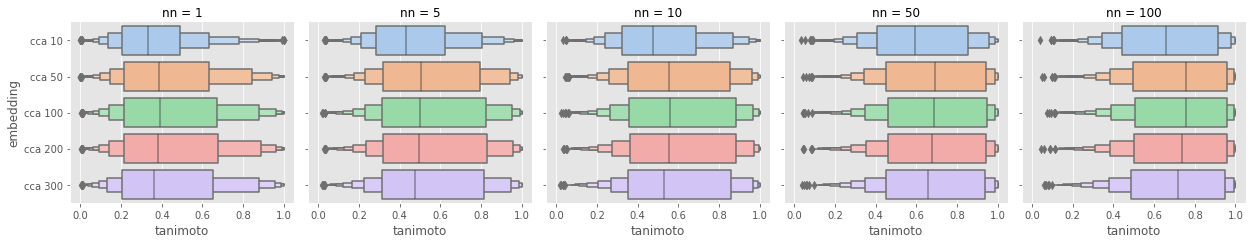

In [10]:
# Make distribution plots
import seaborn as sns 

def make_distribution_plot(tanimoto_df, title, p):
    tanimoto_df_m = tanimoto_df.melt(id_vars=['embedding'], var_name='nn', value_name='tanimoto')
    g = sns.catplot(x='tanimoto', y='embedding', data=tanimoto_df_m, col='nn', kind='boxen', height=3.5, palette='pastel')
    
p = ["darkgray", "orchid", "lightseagreen", "mediumpurple", "chocolate"]

# Combine into one dataframe for plotting
tanimoto_comparison_df = pd.concat([tanimoto_cca_10, tanimoto_cca_50, tanimoto_cca_100, tanimoto_cca_200, tanimoto_cca_300], 
                                      keys=['cca 10', 'cca 50', 'cca 100', 'cca 200', 'cca 300'], names=['embedding']).reset_index(level=[0])
make_distribution_plot(tanimoto_comparison_df, "", p)

#### 2.1.2 DCCA
200 dimensions perform best here.

In [12]:
tanimoto_dcca_10 = get_tanimoto_test(df_spec2vec_dcca_10, nn_list, metric, x='X', y='Y')
tanimoto_dcca_50 = get_tanimoto_test(df_spec2vec_dcca_50, nn_list, metric, x='X', y='Y')
tanimoto_dcca_100 = get_tanimoto_test(df_spec2vec_dcca_100, nn_list, metric, x='X', y='Y')
tanimoto_dcca_200 = get_tanimoto_test(df_spec2vec_dcca_200, nn_list, metric, x='X', y='Y')
tanimoto_dcca_300 = get_tanimoto_test(df_spec2vec_dcca_300, nn_list, metric, x='X', y='Y')

  0%|          | 0/3029 [00:00<?, ?it/s]

  0%|          | 0/3029 [00:00<?, ?it/s]

  0%|          | 0/3029 [00:00<?, ?it/s]

  0%|          | 0/3029 [00:00<?, ?it/s]

  0%|          | 0/3029 [00:00<?, ?it/s]

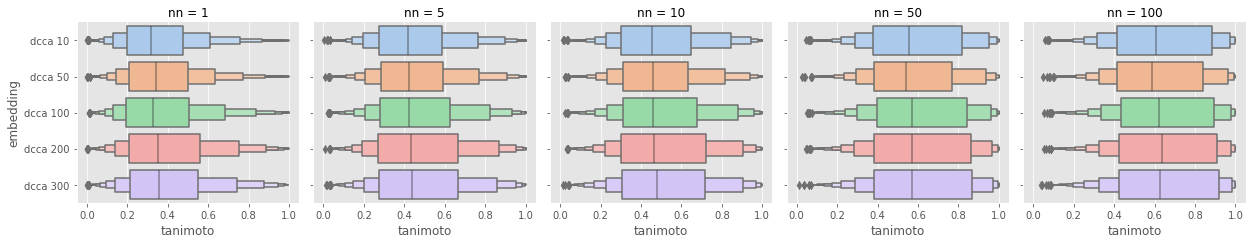

In [13]:
# Combine into one dataframe for plotting
tanimoto_comparison_df_dcca = pd.concat([tanimoto_dcca_10, tanimoto_dcca_50, tanimoto_dcca_100, tanimoto_dcca_200, tanimoto_dcca_300], 
                                      keys=['dcca 10', 'dcca 50', 'dcca 100', 'dcca 200', 'dcca 300'], names=['embedding']).reset_index(level=[0])
make_distribution_plot(tanimoto_comparison_df_dcca, "", p)

### 2.2 Train in train
200 dimensions perform best here.

In [9]:
tanimoto_cca_10_train = get_tanimoto_train(df_spec2vec_cca_10, nn_list, metric, x='X', y='Y')
tanimoto_cca_50_train = get_tanimoto_train(df_spec2vec_cca_50, nn_list, metric, x='X', y='Y')
tanimoto_cca_100_train = get_tanimoto_train(df_spec2vec_cca_100, nn_list, metric, x='X', y='Y')
tanimoto_cca_200_train = get_tanimoto_train(df_spec2vec_cca_200, nn_list, metric, x='X', y='Y')
tanimoto_cca_300_train = get_tanimoto_train(df_spec2vec_cca_300, nn_list, metric, x='X', y='Y')

  0%|          | 0/12116 [00:00<?, ?it/s]

  0%|          | 0/12116 [00:00<?, ?it/s]

  0%|          | 0/12116 [00:00<?, ?it/s]

  0%|          | 0/12116 [00:00<?, ?it/s]

  0%|          | 0/12116 [00:00<?, ?it/s]

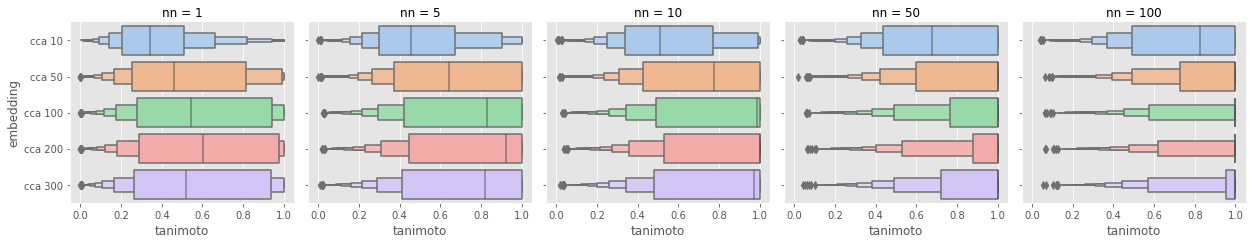

In [11]:
tanimoto_comparison_df_train = pd.concat([tanimoto_cca_10_train, tanimoto_cca_50_train, 
                                          tanimoto_cca_100_train, tanimoto_cca_200_train, tanimoto_cca_300_train], 
                                      keys=['cca 10', 'cca 50', 'cca 100', 'cca 200', 'cca 300'], names=['embedding']).reset_index(level=[0])
make_distribution_plot(tanimoto_comparison_df_train, "", p)